# Setup
**This notebook serves as a demo and tutorial for the yielengine package.**
It illustrates the following methods:
- EDA
- Boruta feature selection
- Shap clustering feature selection
- simulaiton

In [1]:
# Be sure that you are using the yield-engine environement
import sys
print(sys.executable)

C:\Users\martin florent\AppData\Local\Continuum\anaconda3\envs\yield-engine\python.exe


In [2]:
PATH_YIELD_ENGINE = 'src'

def set_paths() -> None:
    """
    set correct working directory and python path when started from within PyCharm
    """
    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir)
        os.chdir(cwd)
    
    print(f"working dir is '{os.getcwd()}'")
                             
    if PATH_YIELD_ENGINE not in sys.path:
        sys.path.insert(0, PATH_YIELD_ENGINE)
    
    print(f"added `{sys.path[0]}` to python paths")

set_paths()

working dir is 'C:\Users\martin florent\Documents\projects\yield-engine'
added `src` to python paths


In [117]:
import logging
import os    
import re
import pprint
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from typing import *

from yieldengine import Sample
from yieldengine.dendrogram import DendrogramDrawer
from yieldengine.dendrogram.style import FeatMapStyle, LineStyle
from yieldengine.df.pipeline import PipelineDF
from yieldengine.preprocessing.encode import OneHotEncoderDF
from yieldengine.preprocessing.impute import SimpleImputerDF, MissingIndicatorDF
from yieldengine.preprocessing.selection import BorutaDF
from yieldengine.preprocessing.compose import ColumnTransformerDF
from yieldengine.model.inspection import ModelInspector
from yieldengine.model.prediction import PredictorCV
from yieldengine.model.selection import Model, ModelGrid, ModelRanker, summary_report, ModelEvaluation, ModelScoring
from yieldengine.model.validation import CircularCrossValidator
from yieldengine.visualization.eda import plot_ecdf, plot_ecdf_df, plot_hist_df
from yieldengine.preprocessing.outlier import TukeyOutlierRemoverDF
from yieldengine.preprocessing import FunctionTransformerDF
from yieldengine.simulation import UnivariateSimulation

In [118]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [105]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
log = logging.getLogger(__name__)

In [32]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Load raw data, EDA and data preprocessing

## Raw data

In [33]:
DATA_DIR = os.path.join('data', 'ames-housing-dataset')
RAW_DATA_CSV = os.path.join(DATA_DIR, 'train.csv')
TARGET = "SalePrice"

In [34]:
print(f"Read {RAW_DATA_CSV}")
raw_df = pd.read_csv(RAW_DATA_CSV)

Read data\ames-housing-dataset\train.csv


## EDA

In [35]:
print(f"Shape of the raw data: {raw_df.shape}")

Shape of the raw data: (1460, 81)


In [36]:
raw_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
raw_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Description of the variables
The variable *description_dict* is a dictionary whose keys are the column names of the dataset and the values are description of the columns

In [38]:
DESCRIPTION = os.path.join(DATA_DIR, 'data_description.txt')
with open(DESCRIPTION, 'r') as f:
    description = f.read()

# Create a dictionary containing description of the variables
splitted = description.split()
idx_begin = [i for i, w in enumerate(description.split()) if w.endswith(':')]
description_dict = {
       splitted[idx_begin[i]][:-1]: ' '.join(splitted[idx_begin[i]+1: idx_begin[i+1]]) for i in range(len(idx_begin)-1)
}

pprint.pprint(description_dict)

{'1stFlrSF': 'First Floor square feet',
 '2ndFlrSF': 'Second floor square feet',
 '3SsnPorch': 'Three season porch area in square feet',
 'Alley': 'Type of alley access to property Grvl Gravel Pave Paved NA No alley '
          'access',
 'Bedroom': 'Bedrooms above grade (does NOT include basement bedrooms)',
 'BldgType': 'Type of dwelling 1Fam Single-family Detached 2FmCon Two-family '
             'Conversion; originally built as one-family dwelling Duplx Duplex '
             'TwnhsE Townhouse End Unit TwnhsI Townhouse Inside Unit',
 'BsmtCond': 'Evaluates the general condition of the basement Ex Excellent Gd '
             'Good TA Typical - slight dampness allowed Fa Fair - dampness or '
             'some cracking or settling Po Poor - Severe cracking, settling, '
             'or wetness NA No Basement',
 'BsmtExposure': 'Refers to walkout or garden level walls Gd Good Exposure Av '
                 'Average Exposure (split levels or foyers typically score '
                 'av

 'LowQualFinSF': 'Low quality finished square feet (all floors)',
 'MSSubClass': 'Identifies the type of dwelling involved in the sale. 20 '
               '1-STORY 1946 & NEWER ALL STYLES 30 1-STORY 1945 & OLDER 40 '
               '1-STORY W/FINISHED ATTIC ALL AGES 45 1-1/2 STORY - UNFINISHED '
               'ALL AGES 50 1-1/2 STORY FINISHED ALL AGES 60 2-STORY 1946 & '
               'NEWER 70 2-STORY 1945 & OLDER 75 2-1/2 STORY ALL AGES 80 SPLIT '
               'OR MULTI-LEVEL 85 SPLIT FOYER 90 DUPLEX - ALL STYLES AND AGES '
               '120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER 150 '
               '1-1/2 STORY PUD - ALL AGES 160 2-STORY PUD - 1946 & NEWER 180 '
               'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER 190 2 FAMILY '
               'CONVERSION - ALL STYLES AND AGES',
 'MSZoning': 'Identifies the general zoning classification of the sale. A '
             'Agriculture C Commercial FV Floating Village Residential I '
             'Industrial RH Re

## Sort by sold date
We sort the samples by selling date

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


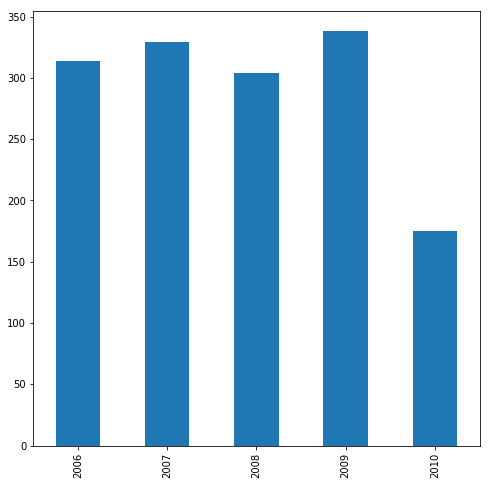

In [39]:
df_tmp = raw_df.copy()
df_tmp['YrSold'].value_counts().sort_index().plot(kind='bar')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


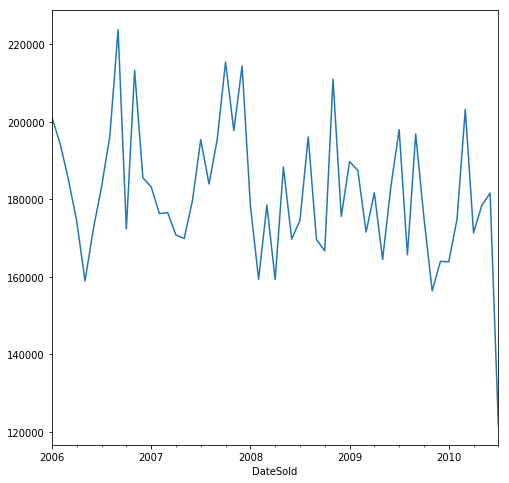

In [40]:
df_tmp['DateSold'] = pd.to_datetime(df_tmp['YrSold']*100 + df_tmp['MoSold'], format='%Y%m')
df_tmp.groupby('DateSold')[TARGET].mean().plot()

## Data Prep

In [41]:
dataset_df = raw_df.copy()
# Sort by the date
dataset_df = dataset_df.sort_values(by=['YrSold', 'MoSold'])
# Drop the Id column and date columns
dataset_df = dataset_df.drop(['Id', 'YrSold', 'MoSold'], axis=1)

In [42]:
# remove infinity values
dataset_df = dataset_df.replace([np.inf, -np.inf], np.nan)

Overview of the types of the features

In [43]:
for col_name in cat_features:
    dataset_df.loc[:, col_name] = (
        dataset_df.loc[:, col_name].astype(object).fillna('missing value').astype(str).str.strip().str.lower().astype('category')
    )
# output datasets
dt = dataset_df.dtypes.rename('dtype').astype(str)
dt.groupby(by=dt.values).count().to_frame()

,dtype
category,43
float64,3
int64,32


For simplicity we select only numerical features

In [44]:
dataset_df = dataset_df[list(num_features) + [TARGET]]

## Remove outliers

In [45]:
outlier_remover = TukeyOutlierRemoverDF(iqr_threshold=1.5)

In [46]:
# Filter out the rows of the dataset where the target is  NaN
print(f"Shape before removal of target outlier: {dataset_df.shape}")
mask = outlier_remover.fit_transform(dataset_df[[TARGET]])[TARGET].notna()
dataset_df = dataset_df.loc[mask, :]
print(f"Shape after removal outlier: {dataset_df.shape}")

Shape before removal of target outlier: (1460, 35)
Shape after removal outlier: (1399, 35)


## Create Sample object to be used by our model

In [47]:
# Define a Sample object to be used by our model
sample_full = Sample(
    observations=dataset_df,
    target_name=TARGET)

* Plot of the empirical cumulative distribution function (ECDF) of the target 

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


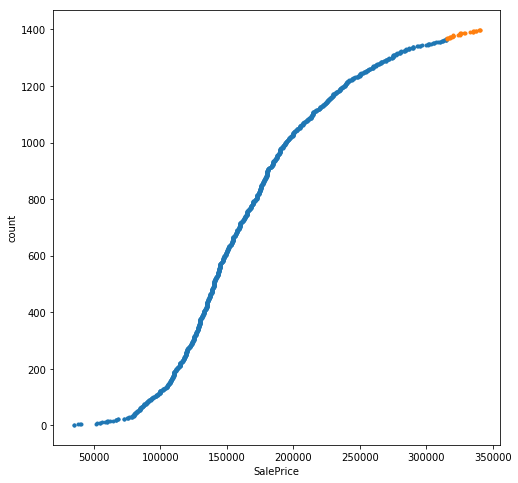

In [50]:
plot_ecdf(sample_full.target)

# Boruta feature selection

## imputation and encoding
We first define a Pipeline that will be used before running Boruta

In [59]:
def make_preprocessor(sample: Sample, onehot: bool = True, missing: bool = True):
    tx = []
    # define how features should be preprocessed
    tx.append(("impute", 
               SimpleImputerDF(strategy="median"), 
               sample.features_by_type(Sample.DTYPE_NUMERICAL).columns))

    if missing:
        tx.append(("missing", 
                   MissingIndicatorDF(error_on_new=False), 
                   sample.features_by_type(Sample.DTYPE_NUMERICAL).columns))
        
    if onehot:
        tx.append(("onehot", 
                   OneHotEncoderDF(sparse=False, handle_unknown="ignore"),
                   sample.features_by_type([Sample.DTYPE_CATEGORICAL]).columns))     

    return ColumnTransformerDF(transformers=tx)

outlier_transformers = [
    ('outlier', TukeyOutlierRemoverDF(iqr_threshold=2), sample_full.features_by_type(Sample.DTYPE_NUMERICAL).columns),
    ('rest', FunctionTransformerDF(validate=False), sample_full.features_by_type(Sample.DTYPE_OBJECT).columns)
]
outlier_step = ColumnTransformerDF(transformers=outlier_transformers)

preprocessor = make_preprocessor(sample=sample_full, missing=True, onehot=True)

## Feature selection (Boruta)

In [60]:
boruta_selector = PipelineDF(
    steps = [
        ('outlier_removal', outlier_step),
        ('preprocess', preprocessor),
        ('boruta', BorutaDF(estimator=RandomForestRegressor(max_depth=5,min_samples_leaf=8,
                                                            random_state=42,n_jobs=-3),
                             n_estimators='auto', verbose=2, max_iter=100, random_state=42))])

In [61]:
boruta_selector.fit(sample_full.features, sample_full.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	59
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	6
Rejected: 	36
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	6
Reject

In [65]:
selected = sorted(list(set(boruta_selector.columns_original)))
print("List of the features selected by Boruta:\n")
pprint.pprint(list(selected))
if selected is None:
    raise Error("You need to specify a backup set of variables")

List of the features selected by Boruta:

['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'Fireplaces',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']


We then create a new sample object containing only the features selected by Boruta. 
- Before Boruta: 34 numercial features
- After Boruta: 18 features

In [71]:
sample = sample_full.select_features(selected)

## Data Visualization of numerical features and categorical features

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


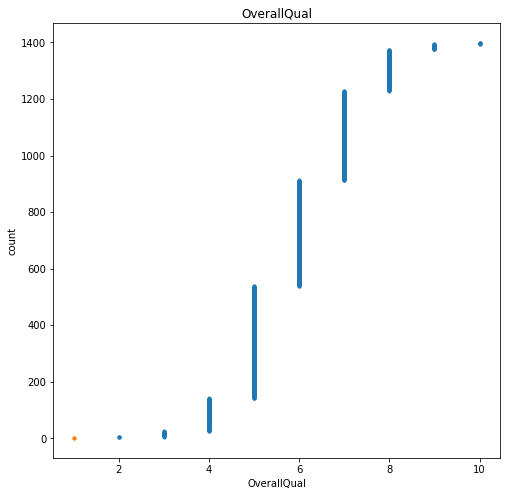

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


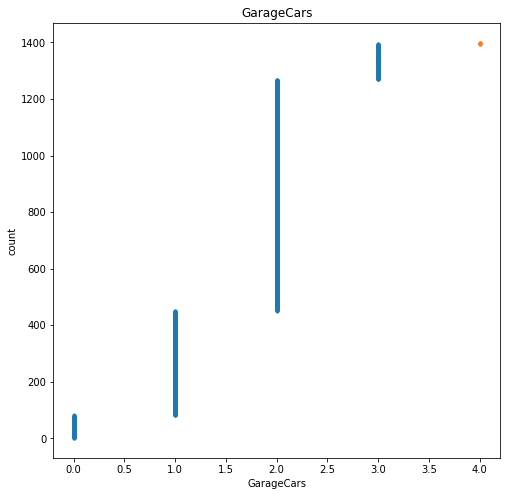

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


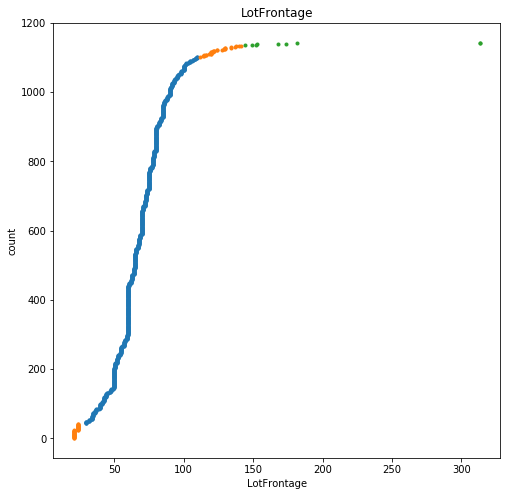

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


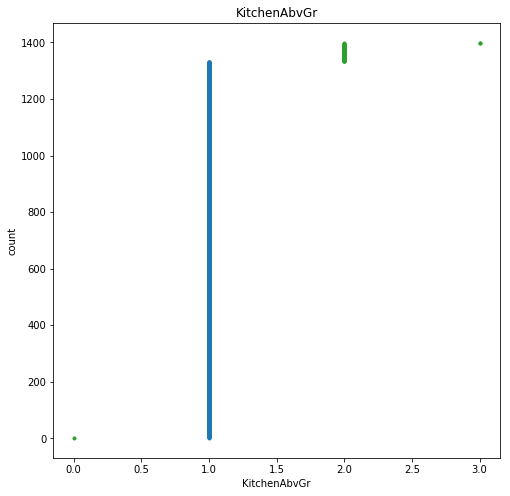

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


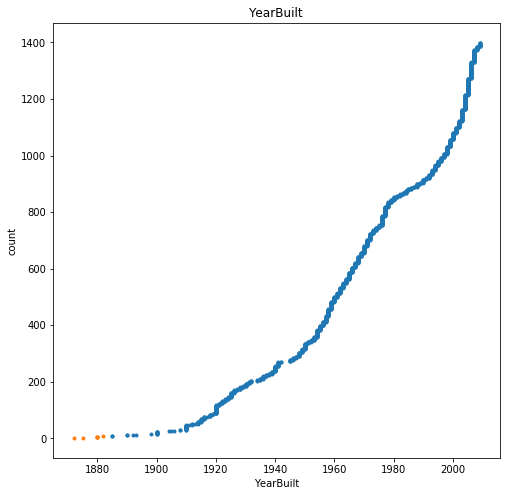

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


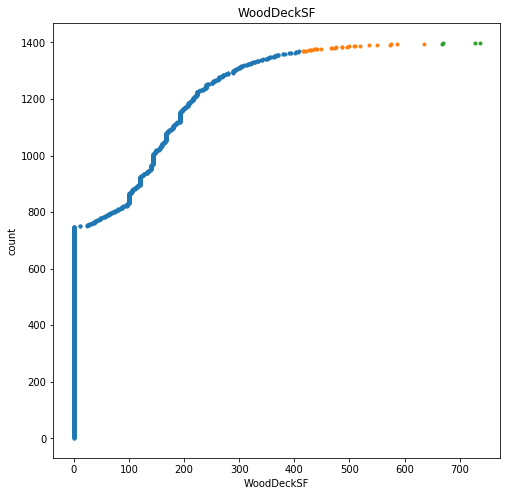

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


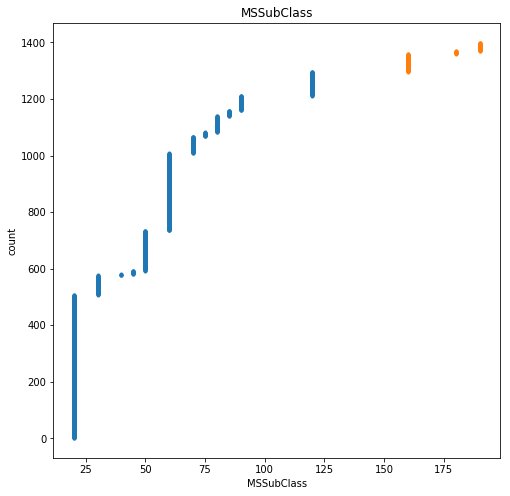

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


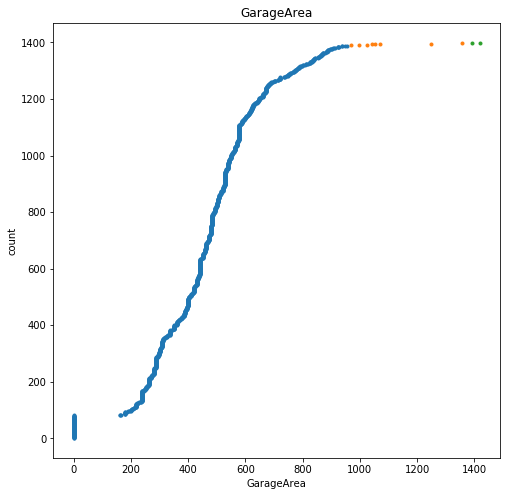

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


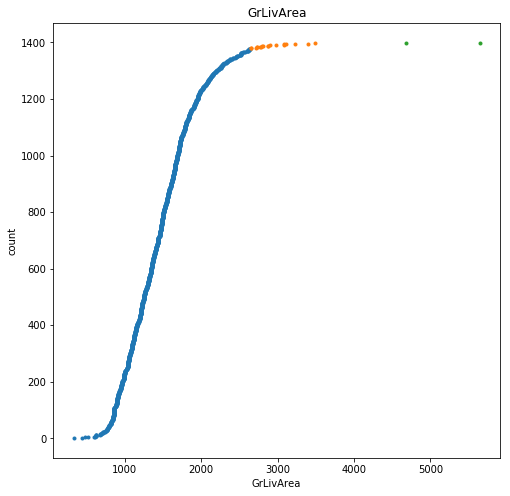

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


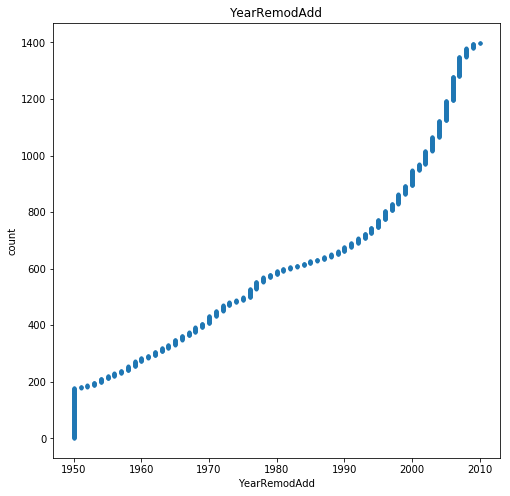

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


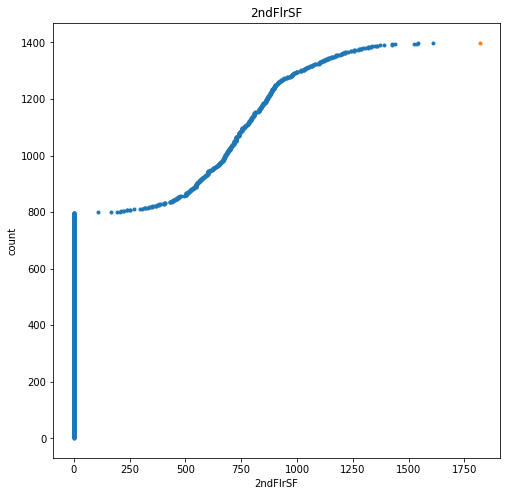

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


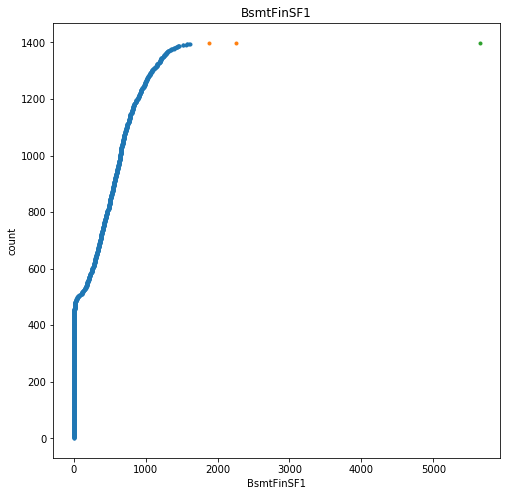

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


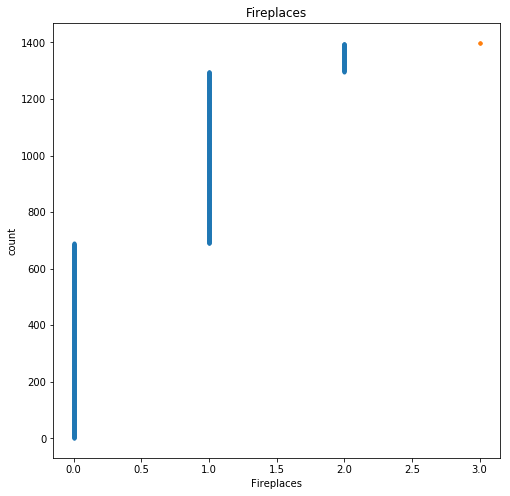

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


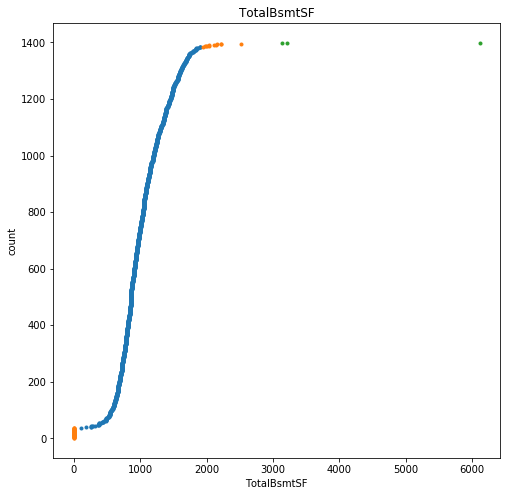

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


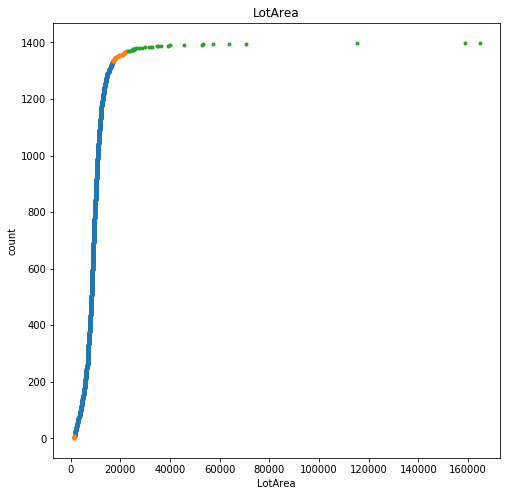

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


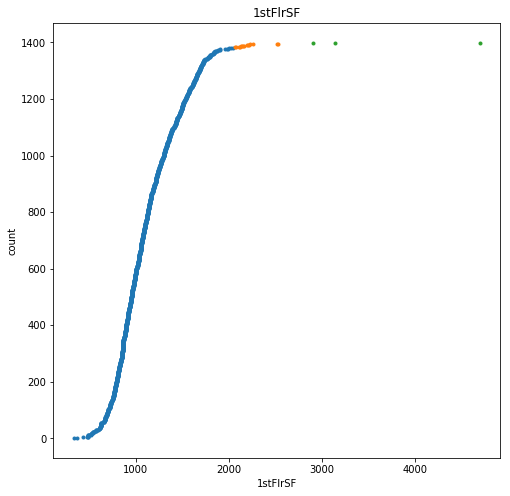

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


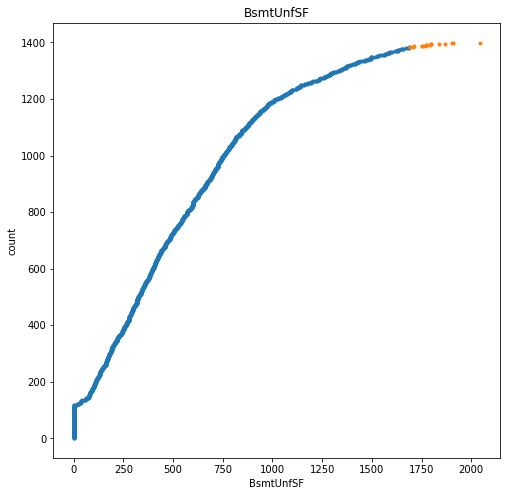

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


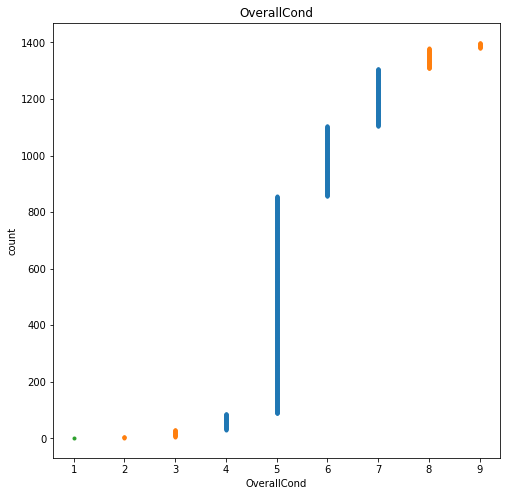

In [72]:
plot_ecdf_df(sample.features)

# Model training


## Grid search and cross validator

In [74]:
# define the circular cross validator with 30 folds
circular_cv = CircularCrossValidator(test_ratio=1/3, num_splits=3)

In [119]:
def get_model_grids():
    girds = [ModelGrid(
         model=Model(estimator=RandomForestRegressor(random_state=42),
                     preprocessing=make_preprocessor(sample=sample, missing=False)),
         estimator_parameters = {"n_estimators": [1000],
                                 "max_depth": [4,5,6],
                                 "min_samples_leaf": [4],
                                 "criterion": ["mse"], #["mae","mse"],
                                 "max_features": [0.4, 0.7, 1.0]})]
    return grids
grids = get_model_grids()

In [80]:
ranker = ModelRanker(grids=grids, cv=circular_cv)

ranking = ranker.run(sample, n_jobs=-3)

print(summary_report(ranking))

Rank  1: RandomForestRegressor, Score=    0.831, test_score_mean=    0.845, test_score_std=  0.00704, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  2: RandomForestRegressor, Score=    0.831, test_score_mean=    0.846, test_score_std=  0.00769, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  3: RandomForestRegressor, Score=     0.83, test_score_mean=    0.837, test_score_std=   0.0038, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=1.0,estimator__min_samples_leaf=4,estimator__n_estimators=1000}

Rank  4: RandomForestRegressor, Score=    0.818, test_score_mean=    0.834, test_score_std=  0.00785, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estima

In [81]:
top_model = ranking[0]
top_model.scoring['test_score']

In [82]:
print(top_model.parameters)

{'estimator__criterion': 'mse', 'estimator__max_depth': 6, 'estimator__max_features': 0.7, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 1000}


## Model inspection

In [85]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample)

inspector = ModelInspector(predictor)

predictions = predictor.predictions_for_all_samples()

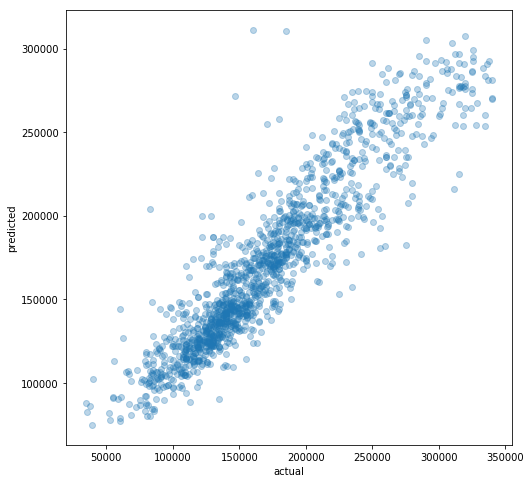

In [106]:
plt.scatter(sample.target.sort_index(), 
            predictions.groupby(predictions.index)['prediction'].mean().sort_index(), alpha=.3)
plt.xlabel('actual')
plt.ylabel('predicted');

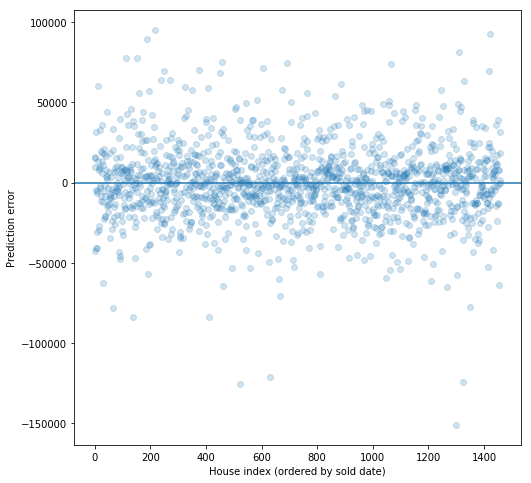

In [107]:
predictions['error'] = (predictions['target'] - predictions['prediction'])
plt.scatter(x=predictions.index.values, y=predictions['error'].values, alpha=.2)
plt.xlabel("House index (ordered by sold date)")
plt.ylabel("Prediction error")
plt.axhline(0);

In [91]:
M = inspector.shap_matrix()

In [108]:
# number_features = predictor.sample.features.shape[1]
# _ = M.plot(subplots=True, figsize=(10, number_features*7))

In [109]:
inspector.shap_matrix().head().T

,0,1,2,3,4
column,,,,,
1stFlrSF,-2748.188060,2983.149450,-2258.550002,-3093.900007,531.416705
2ndFlrSF,752.108219,-1188.138812,819.783176,-447.460011,3386.220401
BsmtFinSF1,763.092080,3136.608865,-898.157972,-3064.487671,175.156862
BsmtUnfSF,467.312206,379.277383,396.178190,-86.857514,1470.914752
Fireplaces,-1063.046071,2627.754803,855.321433,2141.824529,1310.581478
GarageArea,750.894693,-452.582308,3138.644135,1416.178441,8692.516009
GarageCars,1218.655150,1812.273503,1189.963209,4745.334339,3038.544800
GrLivArea,6185.835142,-7820.114307,9871.603802,9088.670230,30706.114004
KitchenAbvGr,78.832007,130.324290,76.564670,139.765012,75.824507


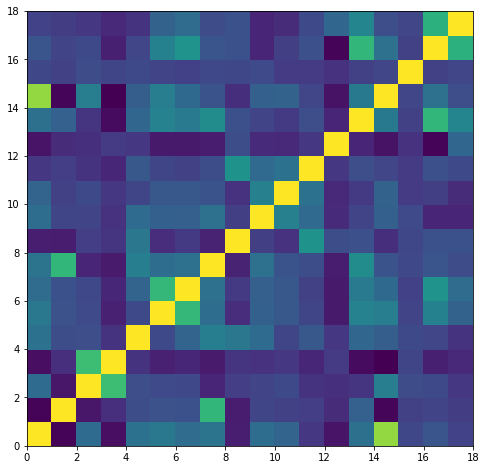

In [111]:
depm = inspector.feature_dependency_matrix()
plt.pcolormesh(depm)

In [112]:
inspector.feature_importances().sort_values(ascending=False).to_frame()

,0
column,
OverallQual,0.317524
GrLivArea,0.209175
YearBuilt,0.096411
TotalBsmtSF,0.078817
GarageArea,0.042953
BsmtFinSF1,0.040624
1stFlrSF,0.039895
GarageCars,0.030887
LotArea,0.030637


## Shap clustering

In [113]:
linkage_tree = inspector.cluster_dependent_features()

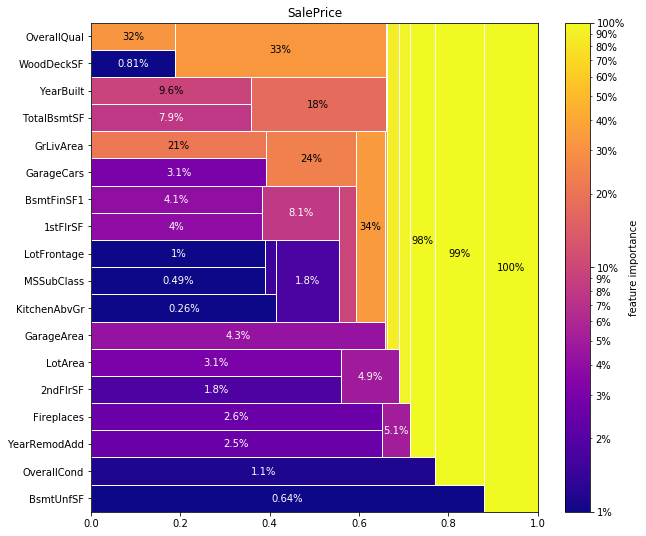

In [115]:
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

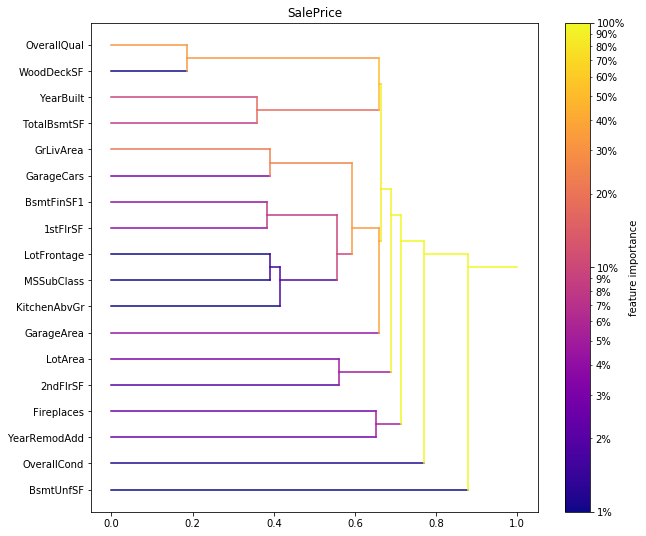

In [116]:
ax = plt.figure(figsize=(10,number_features*0.5)).add_subplot(111)
style = LineStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

# Shap clustering iteration 1

In [ ]:
features1 = sample.feature_names

In [ ]:
black_list1 = ['WoodDeckSF', 
               #'BsmtFinSF1', 
               'BsmtUnfSF', 
               'MasVnrArea',
               'LotFrontage']

In [ ]:
if not set(black_list1) <= features1:
    log.warning(f"""The black list must be a subset of the set of features: the features 
    {set(black_list1)-set(features1)} are in black list but not in the features.""")

In [ ]:
white_list1 = sorted(list(set(features1) - set(black_list1)))
print(f"New white list:\n {white_list1}")

In [ ]:
sample1 = sample.select_features(white_list1)

## Re-run the pipeline

In [ ]:
preprocessor = make_preprocessor(sample=sample1, missing=True, onehot=True)
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample1.features, sample1.target)

In [ ]:
selected1 = sorted(list(set(boruta_selector.columns_original)))
print(list(selected1))
sample1 = sample1.select_features(selected1)

In [ ]:
grids = [
    ModelGrid(
        model=Model(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample1, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [1000],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
)
ranking = ranker.run(sample1, n_jobs=-3)

In [ ]:
print(summary_report(ranking))

In [ ]:
top_model = ranking[0]
print(f"top_model score: {top_model.scoring['test_score']}")

In [ ]:
print(top_model.parameters)

In [ ]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample1)
inspector = ModelInspector(predictor)
M = inspector.shap_matrix()

In [ ]:
linkage_tree = inspector.cluster_dependent_features()
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

In [ ]:
description_dict['OverallCond']

In [ ]:
def shap_culstering_iteration(sample, black_list):

    features = sample.feature_names

    if not set(black_list1) <= features1:
        log.warning(f"""The black list must be a subset of the set of features: the features 
        {set(black_list1)-set(features1)} are in black list but not in the features.""")

    white_list = sorted(list(set(features) - set(black_list)))
    log.info(f"New white list:\n {white_list1}")

    new_sample = sample.select_features(white_list)
    
    
    outlier_transformers = [
    ('outlier', TukeyOutlierRemoverDF(iqr_threshold=2), sample_full.features_by_type(Sample.DTYPE_NUMERICAL).columns),
    ('rest', FunctionTransformerDF(validate=False), sample_full.features_by_type(Sample.DTYPE_OBJECT).columns)
    ]
    outlier_step = ColumnTransformerDF(transformers=outlier_transformers)

    preprocessor = make_preprocessor(sample=sample_full, missing=True, onehot=True)
    
    
    
    
    ## Re-run the pipeline
    preprocessor = make_preprocessor(sample=sample1, missing=True, onehot=True)
    boruta_selector = PipelineDF(
        steps = [
         ('preprocess', preprocessor),
         ('boruta', BorutaDF(estimator=RandomForestRegressor(max_depth=5, min_samples_leaf=8, random_state=42, n_jobs=-3),
                    n_estimators=500, verbose=2, max_iter=100, random_state=42))])

    boruta_selector.fit(new_sample.features, new_sample.target)

    selected = sorted(list(set(boruta_selector.columns_original)))
    print(list(selected))
    new_sample = new_sample.select_features(selected)

    grids = get_model_grids()
    ranker = ModelRanker(grids=grids, cv=circular_cv)
    ranking = ranker.run(sample1, n_jobs=-3)

    print(summary_report(ranking))

    top_model = ranking[0]
    print(f"top_model score: {top_model.scoring['test_score']}")
    print(top_model.parameters)

    predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=new_sample)
    inspector = ModelInspector(predictor)
    
    return new_sample
    M = inspector.shap_matrix()

In [ ]:
linkage_tree = inspector.cluster_dependent_features()
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

description_dict['OverallCond']

# Shap clustering iteration 2

In [ ]:
features2 = sample1.feature_names

In [ ]:
black_list2 = [
    "OverallCond"
]

In [ ]:
if not set(black_list2) <= features2:
    log.warning(f"""The black list must be a subset of the set of features: the features 
    {set(black_list2)-set(features2)} are in black list but not in the features.""")

In [ ]:
assert set(black_list2) <= features2, "The black list must be a subset of the set of features"

In [ ]:
white_list2 = sorted(list(set(features2) - set(black_list2)))
print(f"New white list:\n {white_list2}")

In [ ]:
sample2 = sample1.select_features(white_list2)

## Re-run the pipeline

In [ ]:
preprocessor = make_preprocessor(sample=sample2, missing=True, onehot=True)
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample2.features, sample2.target)

In [ ]:
selected2 = sorted(list(set(boruta_selector.columns_original)))
print(list(selected2))
sample2 = sample2.select_features(selected2)

In [ ]:
grids = [
    ModelGrid(
        model=Model(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample2, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [1000],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
    #scoring='neg_mean_absolute_error'
)
ranking = ranker.run(sample2, n_jobs=-3)

In [ ]:
print(summary_report(ranking))

In [ ]:
top_model = ranking[0]
print(f"top_model score: {top_model.scoring['test_score']}")

In [ ]:
print(top_model.parameters)

In [ ]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample2)
inspector = ModelInspector(predictor)
M = inspector.shap_matrix()

In [ ]:
linkage_tree = inspector.cluster_dependent_features()
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

# Simulation

In [ ]:
sim = UnivariateSimulation(predictor=predictor)

In [ ]:
from IPython.display import display, clear_output
import ipywidgets as widgets



dd = widgets.Dropdown(
    options=predictor.sample.features.columns,
    description='Feature:',
    disabled=False,
    layout={"width":"550px"}
)

btn = widgets.Button(
    description='Simulate'
)

def plot_simulation(feature:str):
    yield_change = sim.simulate_yield_change(
            parameterized_feature=feature,
            parameter_values=UnivariateSimulation.observed_feature_values(
                feature_name=feature,
                sample=predictor.sample,
                min_relative_frequency=0.03,
                limit_observations=100
            ),
    )
    
    yield_change_aggr = UnivariateSimulation.aggregate_simulated_yield_change(
                    results_per_split=yield_change, percentiles=[10, 50, 90])
    
    XLABEL_TITLE = f"{feature}"
    YLABEL_TITLE = f"Predicted mean yield uplift ({TARGET})"
    COLOR1 = 'red'
    COLOR2 = 'silver'
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
    
    # plot lines of prediction
    ax1.set_xlabel(XLABEL_TITLE, color='black', labelpad=10, fontsize=12)
    ax1.set_ylabel(YLABEL_TITLE, color='black', fontsize=12)
    line1, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,0], color=COLOR2, linewidth=1)
    line2, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,1], color=COLOR1)
    line3, = ax1.plot(yield_change_aggr.index, yield_change_aggr.iloc[:,2], color=COLOR2, linewidth=1)
    ax1.axhline(y=0, color='black', linewidth=.5)
    ax1.tick_params(axis='x', labelcolor='black')
    for pos in ['top', 'right', 'bottom']:
        ax1.spines[pos].set_visible(False)
    ax1.tick_params(axis='x', labelbottom=True, bottom=False)
    ax1.legend((line3, line2, line1), 
               ('90th percentile', 'Median', '10th percentile'), 
               frameon=False,
              )
    
    # plot the histogram
    x = sample.features[feature].dropna()
    hist_range = (min(yield_change_aggr.index), max(yield_change_aggr.index))
    n, bins, patches = ax2.hist(x, edgecolor='white', color=COLOR2, range=hist_range)
    bins1 = pd.Series(bins).rolling(window=2).mean().shift(-1).dropna()
    ax2.invert_yaxis()
    ax2.tick_params(axis='y', labelcolor='black')
    max_y = max(n)
    y_offset = max_y * 0.05
    for (x,y) in zip(bins1, n):
        if y>0:
            ax2.text(x, y + y_offset, str(int(y)), 
                    color='black', 
                    horizontalalignment='center')
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    for pos in ['top', 'right', 'left', 'bottom']:
        ax2.spines[pos].set_visible(False)
    plt.subplots_adjust(hspace=.2)
    plt.show()

def on_click(btn):
    clear_output()
    display(widgets.HBox([dd, btn]))
    plot_simulation(feature=dd.value)
    
btn.on_click(on_click)    
display(widgets.HBox([dd, btn]))